## Experiment 1



## Step 0: Load The Data, Model, and Libraries

In [1]:
import os
from dotenv import load_dotenv
import logging
import openai

logging.basicConfig(level=logging.INFO)
logging.getLogger("httpx").setLevel(logging.WARNING)

load_dotenv()

OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY")
client = openai.Client(api_key=OPENAI_API_KEY)


In [2]:
from datasets import load_dataset

ds = load_dataset("HuggingFaceM4/ChartQA")

print("Dataset loaded successfully")

INFO:datasets:PyTorch version 2.5.1 available.
INFO:datasets:TensorFlow version 2.18.0 available.


Dataset loaded successfully


In [3]:
train_ds = ds["train"] # type: ignore
cols = train_ds.column_names # type: ignore
print(cols)

['image', 'query', 'label', 'human_or_machine']


In [4]:
from datasets import Image
train_ds = train_ds.cast_column("image", Image(decode=False))

# Then try to look at the raw data
first_item = train_ds[0]
# Print everything except the image data
print({k: v for k, v in first_item.items() if k != 'image'})

# Let's also check the type of the image data
print("Image data type:", type(first_item['image']))

{'query': 'Is the value of Favorable 38 in 2015?', 'label': ['Yes'], 'human_or_machine': 0}
Image data type: <class 'dict'>


Is the value of Favorable 38 in 2015?
['Yes']


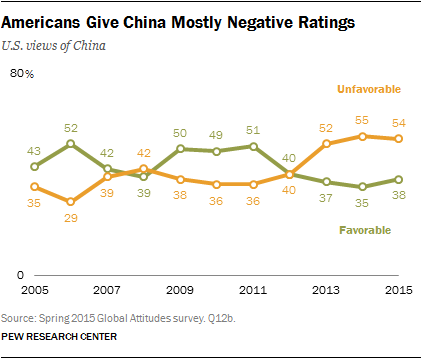

In [5]:
from PIL import Image
import io

img_data = train_ds[0]['image']['bytes']
img = Image.open(io.BytesIO(img_data))
print(train_ds[0]['query'])
print(train_ds[0]['label'])
display(img)  

In [6]:
import base64
import io
    
def image_to_base64(pil_image):
    buffered = io.BytesIO()
    pil_image.save(buffered, format="PNG")
    return base64.b64encode(buffered.getvalue()).decode('utf-8')

In [7]:
from PIL import Image, ImageEnhance
import io
import numpy as np
import cv2

class CustomImageTransformer():
    def __init__(self, img_bytes):
        self.img_bytes = img_bytes
        self.img = Image.open(io.BytesIO(img_bytes))
        
    def apply_gridlines(self, color, thickness):
        img = np.array(self.img)
        
        # Ensure color is broadcast compatible with the image shape
        if len(img.shape) == 3:  # RGB image
            color = np.array(color).reshape(1, 1, -1)  # Make it 3D for broadcasting
        
        for i in range(0, img.shape[0], thickness):
            img[i:i+thickness, :] = np.broadcast_to(color, (thickness, img.shape[1], 3) if len(img.shape) == 3 else (thickness, img.shape[1]))
            
        for i in range(0, img.shape[1], thickness):
            img[:, i:i+thickness] = np.broadcast_to(color, (img.shape[0], thickness, 3) if len(img.shape) == 3 else (img.shape[0], thickness))
            
        return Image.fromarray(img)
    
    def highlight_intersections(self, threshold=30):
        """Highlight points where lines intersect"""
        img_array = np.array(self.img)
        
        # Check if image has alpha channel (RGBA)
        has_alpha = img_array.shape[-1] == 4
        
        # Process RGB channels
        rgb = img_array[..., :3] if has_alpha else img_array
        gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
        edges = cv2.Canny(gray, threshold, threshold*2)
        kernel = np.ones((3,3), np.uint8)
        dilated = cv2.dilate(edges, kernel)
        intersections = cv2.bitwise_and(edges, dilated)
        
        # Create result array with appropriate number of channels
        result = np.copy(img_array)
        intersection_points = intersections > 0
        
        # Create the color array with proper broadcasting
        if has_alpha:
            result[intersection_points, :] = [255, 0, 0, 255]
        else:
            result[intersection_points, :] = [255, 0, 0]
        
        return Image.fromarray(result)

    # Rest of the methods remain the same
    def increae_saturation(self, factor):
        converter = ImageEnhance.Color(self.img)
        return converter.enhance(factor)
        
    def stretch_vertically(self, factor):
        width, height = self.img.size
        return self.img.resize((width, int(height * factor)))
        
    def stretch_horizontally(self, factor):
        width, height = self.img.size
        return self.img.resize((int(width * factor), height))
        
    def apply_grey_scale(self):
        return self.img.convert("L")
        
    def enhance_contrast(self, factor):
        enhancer = ImageEnhance.Contrast(self.img)
        return enhancer.enhance(factor)
        
    def enhance_sharpness(self, factor):
        enhancer = ImageEnhance.Sharpness(self.img)
        return enhancer.enhance(factor)
        
    def enhance_brightness(self, factor):
        enhancer = ImageEnhance.Brightness(self.img)
        return enhancer.enhance(factor)
        
    def add_padding(self, padding, color=(255, 255, 255)):
        width, height = self.img.size
        new_width = width + 2 * padding
        new_height = height + 2 * padding
        result = Image.new(self.img.mode, (new_width, new_height), color)
        result.paste(self.img, (padding, padding))
        return result
        
    def quantize_colors(self, n_colors):
        """Reduce the number of colors in the image"""
        return self.img.quantize(colors=n_colors)
        
    def adaptive_threshold(self, block_size=11, c=2):
        """Apply adaptive thresholding - useful for enhancing chart elements"""
        img_array = np.array(self.img)
        gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
        binary = cv2.adaptiveThreshold(
            gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY, block_size, c
        )
        return Image.fromarray(binary)
        
    def extract_dominant_colors(self, n_colors=5):
        """Extract and emphasize dominant colors"""
        from sklearn.cluster import KMeans
        
        img_array = np.array(self.img)
        has_alpha = img_array.shape[-1] == 4
        
        if has_alpha:
            # Separate RGB and alpha channels
            rgb = img_array[..., :3]
            alpha = img_array[..., 3]
            
            # Reshape RGB for clustering
            pixels_rgb = rgb.reshape(-1, 3)
            
            # Perform clustering on RGB values
            kmeans = KMeans(n_clusters=n_colors)
            kmeans.fit(pixels_rgb)
            
            # Get new RGB values
            new_pixels_rgb = kmeans.cluster_centers_[kmeans.labels_]
            new_rgb = new_pixels_rgb.reshape(rgb.shape)
            
            # Recombine with alpha channel
            result = np.dstack((new_rgb, alpha))
        else:
            # Process RGB image normally
            pixels = img_array.reshape(-1, 3)
            kmeans = KMeans(n_clusters=n_colors)
            kmeans.fit(pixels)
            new_pixels = kmeans.cluster_centers_[kmeans.labels_]
            result = new_pixels.reshape(img_array.shape)
            
        return Image.fromarray(result.astype(np.uint8))
        
    def apply_selective_blur(self, threshold=50):
        """Blur non-essential parts while keeping important features sharp"""
        img_array = np.array(self.img)
        
        # Check number of channels
        n_channels = img_array.shape[-1] if len(img_array.shape) == 3 else 1
        
        if n_channels == 4:  # RGBA
            # Extract RGB and Alpha channels
            rgb = img_array[..., :3]
            alpha = img_array[..., 3]
            
            # Process RGB channels
            edges = cv2.Canny(rgb, threshold, threshold*2)
            blurred = cv2.GaussianBlur(rgb, (5,5), 0)
            mask = edges > 0
            mask_3d = np.stack([mask] * 3, axis=-1)
            
            result_rgb = np.copy(rgb)
            result_rgb[~mask_3d] = blurred[~mask_3d]
            
            # Recombine with alpha channel
            result = np.dstack((result_rgb, alpha))
        else:  # RGB or other format
            edges = cv2.Canny(img_array, threshold, threshold*2)
            blurred = cv2.GaussianBlur(img_array, (5,5), 0)
            mask = edges > 0
            mask_nd = np.stack([mask] * n_channels, axis=-1)
            
            result = np.copy(img_array)
            result[~mask_nd] = blurred[~mask_nd]
        
        return Image.fromarray(result)

In [8]:
def create_image_variations(img_bytes, skip_types=None):
    """
    Create variations of an image using ImageTransformer.
    
    Args:
        img_bytes: Bytes of the input image
        skip_types: List of transformation types to skip. Options are:
            'bw' - Black and white transformations
            'size' - Size manipulations
            'saturation' - Saturation adjustments
            'brightness' - Brightness adjustments
            'contrast' - Contrast adjustments
            'sharpness' - Sharpness adjustments
            'special' - Special transformations
    """
    transformer = CustomImageTransformer(img_bytes)
    variations : dict[str, any] = {"Baseline": transformer.img}
    skip_types = skip_types or []

    # Black and White
    if 'bw' not in skip_types:
        variations["Black and White"] = transformer.apply_grey_scale()

    # Size manipulation
    if 'size' not in skip_types:
        variations.update({
            "Vertically Stretched": transformer.stretch_vertically(2),
            "Horizontally Stretched": transformer.stretch_horizontally(2),
            "Squeezed Vertically": transformer.stretch_vertically(0.5),
            "Squeezed Horizontally": transformer.stretch_horizontally(0.5),
        })

    # Saturation
    if 'saturation' not in skip_types:
        variations.update({
            "Increased Saturation": transformer.increae_saturation(1.8),
            "Decreased Saturation": transformer.increae_saturation(0.3)
        })

    # Brightness
    if 'brightness' not in skip_types:
        variations.update({
            "Increased Brightness": transformer.enhance_brightness(1.8),
            "Decreased Brightness": transformer.enhance_brightness(0.3)
        })

    # Contrast
    if 'contrast' not in skip_types:
        variations.update({
            "Increased Contrast": transformer.enhance_contrast(1.8),
            "Decreased Contrast": transformer.enhance_contrast(0.3)
        })

    # Sharpness
    if 'sharpness' not in skip_types:
        variations.update({
            "Increased Sharpness": transformer.enhance_sharpness(1.8),
            "Decreased Sharpness": transformer.enhance_sharpness(0.3)
        })
        
    print("basic transofrmations done")

    # Special transformations
    if 'special' not in skip_types:
        variations.update({
            "Adaptive Threshold": transformer.adaptive_threshold(),
            "Selective Blur": transformer.apply_selective_blur(),
            "Highlighted Intersections": transformer.highlight_intersections(),
            "Dominant Colors": transformer.extract_dominant_colors(),
            "Quantized Colors": transformer.quantize_colors(5),
            "Padded": transformer.add_padding(20)
        })

    return variations

In [9]:
from pydantic import BaseModel


class Output(BaseModel):
    answer: str
    explanation: str

In [10]:
import pandas as pd
from PIL import Image
import io
import os
import base64

def analyze_image(client, base64_image, query, desc, sample_num, true_label):
    """
    Analyze image using the provided client.
    """
    
    try:
        completion = client.beta.chat.completions.parse(
            model="gpt-4o",
            messages=[
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "text",
                            "text": f"Be concise. {query}"
                        },
                        {
                            "type": "image_url",
                            "image_url": {
                                "url": f"data:image/png;base64,{base64_image}"
                            }
                        }
                    ]
                }
            ],
            max_tokens=300,
            response_format=Output
        )
        
        message = completion.choices[0].message
        if hasattr(message, 'refusal') and message.refusal:
            print(message.refusal)
            return "Refusal"
        else:
            return message.parsed
            
    except Exception as e:
        print(f"Error in analyze_image: {str(e)}")
        print(f"Query: {query}")
        print(f"Description: {desc}")
        return f"Error: {str(e)}"

In [11]:
def process_chart_img(row_data, client, idx, output_dir="data"):
    """
    Process chart image and save transformed images.
    Args:
        row_data: Dictionary with keys 'image', 'query', 'label', 'human_or_machine'
        where 'image' is a dict with 'bytes' and 'path'
    """
    try:
        # Create unique ID for this row
        row_id = f"row_{idx}"
        row_dir = os.path.join(output_dir, row_id)
        os.makedirs(row_dir, exist_ok=True)

        # Extract data from the correct structure
        image_bytes = row_data['image']['bytes']  # Access nested dictionary
        query = row_data['query']
        
        # More robust label handling
        label = row_data['label']
        if isinstance(label, (np.ndarray, pd.Series)):
            true_label = label.iloc[0] if hasattr(label, 'iloc') else label.item()
        elif isinstance(label, list):
            true_label = label[0]
        else:
            true_label = label

        # Create variations
        variations = create_image_variations(image_bytes)
        results = []
        print("variations done for ", idx)
        
        for desc, img in variations.items():
            # Create safe filename
            safe_filename = "".join(x for x in desc if x.isalnum() or x in [' ', '-', '_']).replace(' ', '_')
            img_path = os.path.join(row_dir, f"{safe_filename}.png")
            
            # Save physical image
            img.save(img_path)
            
            # Convert to base64 for csv embedding
            buffered = io.BytesIO()
            img.save(buffered, format="PNG")
            img_base64 = base64.b64encode(buffered.getvalue()).decode()
            
            # Get model prediction
            try:
                prediction = analyze_image(client, img_base64, query, desc, idx, true_label)
            except Exception as e:
                print(f"Error getting prediction for {desc}: {str(e)}")
                prediction = f"Error: {str(e)}"
            
            results.append({
                'Row_ID': row_id,
                'Variation': desc,
                'Query': query,
                'True_Label': true_label,
                'Prediction': prediction,
                'Image_Path': img_path,
                'Image_Base64': img_base64
            })
            
        return results
    
    except Exception as e:
        print(f"Error in process_chart_img: {str(e)}")
        print(f"Row data keys: {row_data.keys()}")
        # Add more debugging information
        print(f"Label type: {type(row_data['label'])}")
        if isinstance(row_data['label'], (np.ndarray, pd.Series)):
            print(f"Label shape: {row_data['label'].shape}")
            print(f"Label values: {row_data['label']}")
        raise e

In [12]:
def create_html_csv(results, output_dir="data", name="results"):
    """Create an HTML-formatted CSV with viewable images and evaluation results."""
    df = pd.DataFrame(results)
    print("saving html and csv")
    
    html_path = os.path.join(output_dir, f"{name}.html")
    try:
        if 'Image_Base64' in df.columns:
            df['Image_HTML'] = df['Image_Base64'].apply(
                lambda x: f'<img src="data:image/png;base64,{x}" style="max-width:200px;">'
            )
        else:
            print("Warning: Image_Base64 column not found")
            return None, None
        
        # Add styling for correct/incorrect predictions
        html_content = """
        <html>
        <head>
        <style>
            table { border-collapse: collapse; width: 100%; }
            th, td { border: 1px solid #ddd; padding: 8px; text-align: left; }
            th { background-color: #f2f2f2; }
            img { max-width: 200px; height: auto; }
            .correct { background-color: #d4edda; }
            .incorrect { background-color: #f8d7da; }
        </style>
        </head>
        <body>
        """
        
        # Include evaluation results in columns
        available_columns = ['Row_ID', 'Variation', 'Query', 'True_Label', 'Prediction', 'Is_Correct', 'Image_HTML']
        columns_to_use = [col for col in available_columns if col in df.columns]
        
        # Convert DataFrame to HTML with row styling based on correctness
        df_html = df[columns_to_use].to_html(
            escape=False,
            index=False,
            classes='results-table',
            table_id='results'
        )
        
        # Add JavaScript for dynamic row coloring
        html_content += """
        <script>
        document.addEventListener('DOMContentLoaded', function() {
            var table = document.getElementById('results');
            var rows = table.getElementsByTagName('tr');
            for (var i = 1; i < rows.length; i++) {
                var isCorrect = rows[i].cells[columns_to_use.indexOf('Is_Correct')].innerText;
                if (isCorrect === 'true') {
                    rows[i].classList.add('correct');
                } else if (isCorrect === 'false') {
                    rows[i].classList.add('incorrect');
                }
            }
        });
        </script>
        """
        
        html_content += df_html
        html_content += "</body></html>"
        
        with open(html_path, 'w') as f:
            f.write(html_content)
        
        # Save CSV with evaluation results
        csv_path = os.path.join(output_dir, f"{name}.csv")
        csv_columns = [col for col in ['Row_ID', 'Variation', 'Query', 'True_Label', 
                                     'Prediction', 'Is_Correct', 'Image_Path']
                      if col in df.columns]
        df[csv_columns].to_csv(csv_path, index=False)
        
        print("saved html and csv")
        return html_path, csv_path
        
    except Exception as e:
        print(f"Error in create_html_csv: {str(e)}")
        print(f"DataFrame info: {df.info()}")
        return None, None

In [13]:
# Test the client before processing
def test_client(client):
    """Test if the client is valid"""
    print(f"Testing client of type: {type(client)}")
    print(f"Client attributes: {dir(client)}")
    return hasattr(client, 'beta') and hasattr(client.beta, 'chat')

In [14]:
class EvalOutput(BaseModel):
    is_correct: bool
    
def evaluate_prediction(prediction, true_label):
    
    try:
        completion = client.beta.chat.completions.parse(
            model="gpt-4o",
            messages=[
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "text",
                            "text": f"Does the following prediction match the true label? Prediction: {prediction}, True Label: {true_label}"
                        }
                    ]
                }
            ],
            max_tokens=300,
            response_format=EvalOutput
        )
        
        message = completion.choices[0].message
        if hasattr(message, 'refusal') and message.refusal:
            print(message.refusal)
            return "Refusal"
        else:
            return message.parsed
            
    except Exception as e:
        print(f"Error in evaluate_prediction: {str(e)}")
        print(f"Prediction: {prediction}")
        print(f"True Label: {true_label}")
        return f"Error: {str(e)}"

In [15]:
def process_dataset(dataset, client, start_idx=0, num_rows=None, output_dir="data"):
    """Process multiple rows from the dataset."""
    all_results = []
    
    # Convert dataset to list if needed
    if hasattr(dataset, 'to_list'):
        processed_rows = dataset.to_list()
    else:
        processed_rows = list(dataset)
    
    # Now slice the list
    start = start_idx
    end = start_idx + num_rows if num_rows is not None else None
    processed_rows = processed_rows[start:end]
    
    # print(f"Processing {len(processed_rows)} rows")
    
    for i, row in enumerate(processed_rows):
        try:
            print(f"\nProcessing dataset row {start_idx + i}")
            results = process_chart_img(row, client, start_idx + i, output_dir)
            if results:
                # Add evaluation for each variation
                for result in results:
                    is_correct = evaluate_prediction(result['Prediction'], result['True_Label'])
                    result['Is_Correct'] = is_correct.is_correct if is_correct else "Unknown"
                all_results.extend(results)
        except Exception as e:
            print(f"Error processing row {start_idx + i}: {str(e)}")
            raise e
    
    if not all_results:
        print("No results to process")
        return None, None
    
    return all_results


In [16]:
def inspect_dict(d):
    print("\nDictionary Inspection:")
    print(f"Type: {type(d)}")
    print("Keys:", d.keys())
    for key in d.keys():
        print(f"\nKey: {key}")
        print(f"Value type: {type(d[key])}")
        if isinstance(d[key], dict):
            print("Nested keys:", d[key].keys())

# Run this with your first sample
sample = train_ds[0]
inspect_dict(sample)


Dictionary Inspection:
Type: <class 'dict'>
Keys: dict_keys(['image', 'query', 'label', 'human_or_machine'])

Key: image
Value type: <class 'dict'>
Nested keys: dict_keys(['bytes', 'path'])

Key: query
Value type: <class 'str'>

Key: label
Value type: <class 'list'>

Key: human_or_machine
Value type: <class 'int'>


In [17]:
# batch_size = 10
# number_of_batches = 10

# all_results = []

# for i in range(0, number_of_batches * batch_size, batch_size):
#     print(f"\nProcessing batch {i} to {i + batch_size}")
#     res = process_dataset(train_ds, client, start_idx=i, num_rows=batch_size)
#     all_results.extend(res)


In [18]:
# html_path, csv_path = create_html_csv(all_results, output_dir="data")

In [19]:
# First cell - imports and functions
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import HTML, display

def load_and_process_results(file_path='data/results.csv'):
    """
    Load the CSV file and process the results
    """
    # Read the CSV file
    df_data_res = pd.read_csv(file_path)
    
    # Calculate success rates by variation
    success_rates = (df_data_res.groupby('Variation')
                    .agg({
                        'Is_Correct': ['count', 'sum', 'mean']
                    })
                    .round(4))
    
    # Flatten column names
    success_rates.columns = ['Total_Samples', 'Correct_Predictions', 'Success_Rate']
    
    # Reset index to make Variation a column
    success_rates = success_rates.reset_index()
    
    # Sort by Success_Rate in descending order
    success_rates = success_rates.sort_values('Success_Rate', ascending=False)
    
    return df_data_res, success_rates

def create_performance_charts(success_rates):
    """
    Create visualizations for the performance metrics
    Returns two Plotly figures
    """
    # Create bar chart for success rates
    fig1 = px.bar(
        success_rates,
        x='Variation',
        y='Success_Rate',
        title='Success Rate by Variation',
        labels={'Success_Rate': 'Success Rate', 'Variation': 'Model Variation'},
        color='Success_Rate',
        color_continuous_scale='viridis'
    )
    fig1.update_layout(
        xaxis_tickangle=-45,
        yaxis_range=[0, 1],
        height=500
    )
    
    # Create scatter plot for sample counts
    fig2 = go.Figure()
    fig2.add_trace(go.Scatter(
        x=success_rates['Variation'],
        y=success_rates['Total_Samples'],
        mode='markers+lines',
        name='Total Samples'
    ))
    fig2.add_trace(go.Scatter(
        x=success_rates['Variation'],
        y=success_rates['Correct_Predictions'],
        mode='markers+lines',
        name='Correct Predictions'
    ))
    fig2.update_layout(
        title='Sample Distribution by Variation',
        xaxis_tickangle=-45,
        height=500,
        showlegend=True
    )
    
    return fig1, fig2

def display_results_table(success_rates):
    """
    Create a formatted HTML table of the results
    """
    styled_df = success_rates.style.format({
        'Success_Rate': '{:.2%}',
        'Total_Samples': '{:,.0f}',
        'Correct_Predictions': '{:,.0f}'
    })
    return styled_df

# Second cell - analysis execution
# Load and analyze the data
df_data_res, success_rates = load_and_process_results('data/results.csv')

# Display the formatted table
print("Results Summary (Sorted by Success Rate):")
display(display_results_table(success_rates))

# Create and display the charts
fig1, fig2 = create_performance_charts(success_rates)
display(fig1)
display(fig2)

# Optional: Save to HTML file
html_content = f"""
<!DOCTYPE html>
<html>
<head>
    <title>Results Analysis</title>
    <style>
        body {{
            font-family: Arial, sans-serif;
            margin: 20px;
            max-width: 1200px;
            margin: 0 auto;
            padding: 20px;
        }}
        .results-container {{
            margin-bottom: 30px;
        }}
        table {{
            border-collapse: collapse;
            width: 100%;
            margin-bottom: 20px;
        }}
        th, td {{
            border: 1px solid #ddd;
            padding: 8px;
            text-align: left;
        }}
        th {{
            background-color: #f4f4f4;
        }}
    </style>
</head>
<body>
    <h1>Results Analysis</h1>
    <div class="results-container">
        <h2>Performance Summary</h2>
        {display_results_table(success_rates).to_html()}
    </div>
    <div class="results-container">
        <h2>Performance Charts</h2>
        {fig1.to_html(full_html=False)}
        {fig2.to_html(full_html=False)}
    </div>
</body>
</html>
"""

with open('results_analysis.html', 'w', encoding='utf-8') as f:
    f.write(html_content)

Results Summary (Sorted by Success Rate):


,Variation,Total_Samples,Correct_Predictions,Success_Rate
19,Vertically Stretched,17,14,82.35%
4,Decreased Contrast,17,14,82.35%
18,Squeezed Vertically,17,13,76.47%
17,Squeezed Horizontally,17,13,76.47%
5,Decreased Saturation,17,13,76.47%
6,Decreased Sharpness,17,13,76.47%
11,Increased Contrast,17,12,70.59%
14,Padded,17,12,70.59%
0,Adaptive Threshold,17,12,70.59%
7,Dominant Colors,17,12,70.59%


In [20]:
import os
import pandas as pd

def initialize_csv(output_dir: str = "data", name: str = "results"):
    os.makedirs(output_dir, exist_ok=True)
    csv_path = os.path.join(output_dir, f"{name}.csv")
    
    if not os.path.exists(csv_path):
        df = pd.DataFrame(columns=['Row_ID', 'Variation', 'Query', 'True_Label', 
                                 'Prediction', 'Is_Correct', 'Image_Path'])
        df.to_csv(csv_path, index=False)
    
    return csv_path

def add_row_to_csv(row_data, csv_path):
    new_row = pd.DataFrame([row_data])
    new_row.to_csv(csv_path, mode='a', header=False, index=False)

In [21]:
from IPython.display import display
from ipywidgets import Button, HBox, Label, HTML
import random
from typing import List, Dict


def process_random_samples(
    dataset,
    client,
    max_samples: int,
    output_dir: str = "data",
    name: str = "results",
    batch_size: int = 10
) -> List[Dict]:
    # Initialize CSV with correct columns
    csv_path = initialize_csv(output_dir, name)
    print(f"CSV initialized at {csv_path}")
    
    # Create stop button and status label
    stop_button = Button(description='Stop Processing',
                        button_style='danger',
                        layout={'width': '150px'})
    status_label = Label(value='Processing...')
    stop_flag = False
    
    def on_stop_button_clicked(b):
        nonlocal stop_flag
        stop_flag = True
        status_label.value = 'Stopping after current batch...'
        stop_button.disabled = True
    
    stop_button.on_click(on_stop_button_clicked)
    display(HBox([stop_button, status_label]))
    
    # Generate random indices
    try:
        total_size = len(dataset)
        sample_size = min(max_samples, total_size)
        random_indices = random.sample(range(total_size), sample_size)
        all_results = []
        
        # Process in batches for efficiency
        for i in range(0, len(random_indices), batch_size):
            if stop_flag:
                print("\nProcessing stopped by user")
                break
            
            try:
                batch_indices = random_indices[i:i + batch_size]
                print(f"\nProcessing batch {i//batch_size + 1}, "
                      f"samples {i} to {min(i + batch_size, sample_size)}")
                
                # Process the batch
                batch_results = process_dataset(
                    dataset,
                    client,
                    start_idx=batch_indices[0],
                    num_rows=len(batch_indices)
                )
                
                for result in batch_results:
                    row_data = {
                        'Row_ID': result['Row_ID'],
                        'Variation': result['Variation'],
                        'Query': result['Query'],
                        'True_Label': result['True_Label'],
                        'Prediction': result['Prediction'],
                        'Is_Correct': result['Is_Correct'],
                        'Image_Path': result['Image_Path']
                    }
                    add_row_to_csv(row_data, csv_path)
                    all_results.append(row_data)                    
            except KeyboardInterrupt:
                print("\nProcessing interrupted by user. Saving current results...")
                break
                
    except Exception as e:
        print(f"Error during processing: {str(e)}")
        
    finally:
        print(f"\nProcessed {len(all_results)} samples")
        return all_results

In [22]:
# results = process_random_samples(
#     dataset=train_ds,
#     client=client,
#     max_samples=100,
#     output_dir="data",
#     name="results",
#     batch_size=1
# )

In [23]:
df_data_res, success_rates = load_and_process_results('results/results.csv')

# Display the formatted table
print("Results Summary (Sorted by Success Rate):")
styled_table = display_results_table(success_rates)
display(styled_table)

# Save the underlying data as CSV (without styling)
styled_table.data.to_csv('results/summary_results.csv', index=False)

# Create and display the charts
fig1, fig2 = create_performance_charts(success_rates)
display(fig1)
display(fig2)

# Optional: Save to HTML file
html_content = f"""
<!DOCTYPE html>
<html>
<head>
    <title>Results Analysis</title>
    <style>
        body {{
            font-family: Arial, sans-serif;
            margin: 20px;
            max-width: 1200px;
            margin: 0 auto;
            padding: 20px;
        }}
        .results-container {{
            margin-bottom: 30px;
        }}
        table {{
            border-collapse: collapse;
            width: 100%;
            margin-bottom: 20px;
        }}
        th, td {{
            border: 1px solid #ddd;
            padding: 8px;
            text-align: left;
        }}
        th {{
            background-color: #f4f4f4;
        }}
    </style>
</head>
<body>
    <h1>Results Analysis</h1>
    <div class="results-container">
        <h2>Performance Summary</h2>
        {styled_table.to_html()}
    </div>
    <div class="results-container">
        <h2>Performance Charts</h2>
        {fig1.to_html(full_html=False)}
        {fig2.to_html(full_html=False)}
    </div>
</body>
</html>
"""

with open('results_analysis.html', 'w', encoding='utf-8') as f:
    f.write(html_content)

Results Summary (Sorted by Success Rate):


,Variation,Total_Samples,Correct_Predictions,Success_Rate
4,Decreased Contrast,108,73,67.59%
11,Increased Contrast,108,72,66.67%
19,Vertically Stretched,108,71,65.74%
9,Horizontally Stretched,108,70,64.81%
18,Squeezed Vertically,108,69,63.89%
3,Decreased Brightness,108,69,63.89%
6,Decreased Sharpness,108,69,63.89%
17,Squeezed Horizontally,108,67,62.04%
14,Padded,108,63,58.33%
5,Decreased Saturation,108,62,57.41%


In [24]:
results3 = process_random_samples(
    dataset=train_ds,
    client=client,
    max_samples=300,
    output_dir="data",
    name="results5",
    batch_size=1
)

CSV initialized at data/results5.csv



Processing batch 1, samples 0 to 1

Processing dataset row 9187
basic transofrmations done
variations done for  9187

Processing interrupted by user. Saving current results...

Processed 0 samples


In [25]:
from pydantic import BaseModel
from typing import Literal

# Create a Pydantic class with Literal type for strict chart type validation
class ChartTypeOutput(BaseModel):
    chart_type: Literal[
        "bar", 
        "line", 
        "scatter", 
        "pie", 
        "area", 
        "heatmap", 
        "box", 
        "bubble", 
        "treemap", 
        "radar", 
        "other"
    ]

def generate_chart_type(client, base64_image):
    """
    Analyze image and determine the chart type.
    Returns a ChartTypeOutput with the predicted chart type.
    """
    try:
        completion = client.beta.chat.completions.parse(
            model="gpt-4o",
            messages=[
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "text",
                            "text": "What type of chart is this? Respond with only one of these types: bar, line, scatter, pie, area, heatmap, box, bubble, treemap, radar, other"
                        },
                        {
                            "type": "image_url",
                            "image_url": {
                                "url": f"data:image/png;base64,{base64_image}"
                            }
                        }
                    ]
                }
            ],
            max_tokens=300,
            response_format=ChartTypeOutput
        )
        
        message = completion.choices[0].message
        if hasattr(message, 'refusal') and message.refusal:
            print(message.refusal)
            return "Refusal"
        else:
            return message.parsed
            
    except Exception as e:
        print(f"Error in generate_chart_type: {str(e)}")
        return f"Error: {str(e)}"

In [26]:
df_data_res, success_rates = load_and_process_results('data/results4.csv')

print(df_data_res.head())

FileNotFoundError: [Errno 2] No such file or directory: 'data/results4.csv'

In [27]:
def process_chart_types(df_data_res, trains_ds, client):
    """
    Process all unique chart IDs from results and generate chart types.
    Args:
        df_data_res: DataFrame containing results with row_id column
        trains_ds: Original training DataFrame with image data
        client: API client for making predictions
    """
    # Extract unique row IDs from results and convert to numeric indices
    raw_ids = set(df_data_res['Row_ID'].unique())
    unique_ids = {int(row_id.split('_')[1]) for row_id in raw_ids}  # Convert 'Row_X' to X
    print(f"Found {len(unique_ids)} unique IDs to process")
    
    results = []
    for idx in unique_ids:
        try:
            # Get corresponding row from training data
            train_row = trains_ds[idx]
            
            # Extract image bytes - adjust this based on your trains_ds structure
            image_bytes = train_row['image']['bytes']
            
            # Convert to base64
            img_base64 = base64.b64encode(image_bytes).decode()
            
            # Generate chart type prediction
            prediction = generate_chart_type(client, img_base64)
            
            results.append({
                'row_id': f'Row_{idx}',  # Convert back to original format for consistency
                'predicted_chart_type': prediction.chart_type if isinstance(prediction, ChartTypeOutput) else str(prediction)
            })
            
            if len(results) % 10 == 0:
                print(f"Processed {len(results)}/{len(unique_ids)} images")
                
        except Exception as e:
            print(f"Error processing row {idx}: {str(e)}")
            results.append({
                'row_id': f'Row_{idx}',
                'predicted_chart_type': f"Error: {str(e)}"
            })
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    return results_df

# Usage:
# results_df = process_chart_types(df_data_res, train_ds, client)
# # Save results if needed
# results_df.to_csv('chart_type_predictions.csv', index=False)

In [28]:
import pandas as pd
import plotly.express as px
import plotly.io as pio

# Load and process the data
df_data_res, success_rates = load_and_process_results('results/results.csv')

# Let's check the actual column names
print("Column names in success_rates DataFrame:")
print(success_rates.columns)

# Assuming your CSV columns are actually "Variation", "Total_Samples", "Correct_Predictions", "Success_Rate"
# Modified code using correct column names:

with open('results/table_results.tex', 'w') as f:
    f.write(r'''\begin{table*}
  \centering
  \begin{tabular}{lrrr}
    \hline
    \textbf{Variation} & \textbf{Total Samples} & \textbf{Correct Predictions} & \textbf{Success Rate} \\
    \hline''')
    
    for _, row in success_rates.iterrows():
        f.write(f"\n    {row['Variation']} & {row['Total_Samples']} & {row['Correct_Predictions']} & {row['Success_Rate']:.3f} \\\\")
    
    f.write(r'''
    \hline
  \end{tabular}
  \caption{\label{tab:variation-results}
    Performance comparison across different image variations. All variations were tested on the same number of samples (108), with success rates ranging from 43.5\% to 67.6\%.
  }
\end{table*}
''')

def create_performance_charts(success_rates):
    # Success Rate Chart
    fig1 = px.bar(success_rates, 
                  x='Variation', 
                  y='Success_Rate',
                  title='Success Rate by Variation')
    
    fig1.update_layout(
        width=800,
        height=500,
        xaxis_tickangle=45,
        margin=dict(l=50, r=50, t=50, b=100),
        font=dict(size=12)
    )
    
    # Sample Count Chart
    fig2 = px.bar(success_rates, 
                  x='Variation', 
                  y='Total_Samples',
                  title='Sample Count by Variation')
    
    fig2.update_layout(
        width=800,
        height=500,
        xaxis_tickangle=45,
        margin=dict(l=50, r=50, t=50, b=100),
        font=dict(size=12)
    )
    
    return fig1, fig2

# Create charts
fig1, fig2 = create_performance_charts(success_rates)

# Save as PNG files with higher resolution
pio.write_image(fig1, "results/success_rate_chart.png", scale=2)
pio.write_image(fig2, "results/sample_count_chart.png", scale=2)

print("Files saved: table_results.tex, success_rate_chart.png, sample_count_chart.png")

Column names in success_rates DataFrame:
Index(['Variation', 'Total_Samples', 'Correct_Predictions', 'Success_Rate'], dtype='object')
Files saved: table_results.tex, success_rate_chart.png, sample_count_chart.png
